In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import time
import re
import nltk
import math
import os
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score
import sklearn.metrics
from sklearn.metrics import confusion_matrix
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from imblearn.over_sampling import SMOTE

%matplotlib inline


In [2]:
def fasta_parser(filename):
    if os.path.exists(filename):
        pass
    else:                     
        print("The file, %s, does not exist" % filename)
        
    file = open(filename,mode='r')
    rec_all = file.read()
    file.close()
    # remove all whitespace from string all_of_it
    rec_all = rec_all.replace(' ','')
    # split records by > 
    records = rec_all.split('>')
    # Parse out the headers & sequences for each record
    headers = []
    sequences = []
    for rec in records:
        s = ''
        data = rec.split('\n')
        sq = s.join(data[1:])
        if len(data[0]) > 0:
            headers.append(data[0])
   
        if (len(sq) > 0):
            sequences.append(s.join(data[1:]))
    #print(sequences)
    return headers, sequences

## The dataset contains 5959 proteins annotated to one of 11 different subcellular locations which are: chloroplast, cytoplasm, endoplasmic reticulum, extracellular space, Golgi apparatus, lysosomal, mitochondrion, nucleus, peroxisome, plasma membrane and vacuole which represented proteins of plants cell and fungal cell while animal cells shared all localizations with them, but have lysosomes instead of vacuoles. The only variable we intend to consider is protein sequence.


In [3]:
# data downloaded from kaggle
# https://www.kaggle.com/lzyacht/proteinsubcellularlocalization/downloads/proteinsubcellularlocalization.zip/1
# data is from SWISS-PROT database release 42 (2003–2004)
df = pd.read_csv('proteinsLocations.csv')
df.head(3)

,label,name,sequence
0,chloroplast.fasta,P46644 cTP 43,MKTTHSSSSSSDRRGARHNSGSDSDNSSYASTSGGTGGSVSHVADG...
1,chloroplast.fasta,P46248 cTP 52,MASMSGSTSRNKDKKGTSASNKAKSSRVTMTVAVKSRGTMADGVSA...
2,chloroplast.fasta,Q96375 cTP 49,MYASSARDGGKWCNARRKSKDAYHSCKSNGHKKVKGVKATAAATTK...


In [4]:
df.shape

(5959, 3)

In [5]:
df.dtypes

label       object
name        object
sequence    object
dtype: object

In [6]:
df.label.value_counts()

cytoplasmic.fasta        1411
plasma_membrane.fasta    1238
extracellular.fasta       843
nuclear.fasta             837
mitochondrial.fasta       510
chloroplast.fasta         449
ER.fasta                  198
peroxisomal.fasta         157
Golgi.fasta               150
lysosomal.fasta           103
vacuolar.fasta             63
Name: label, dtype: int64

In [7]:
df.isnull().sum()

label       0
name        0
sequence    0
dtype: int64

## Encode different subcellular locations as integers

In [8]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df.label)
df['location'] = le.transform(df['label'])

In [9]:
# remove non-coding amino acid letters like X
df['sequence'] = df['sequence'].str.replace('X','G')
df['sequence'] = df['sequence'].str.replace('B','G')

## Derive Features Using Biopython

In [10]:
df['MW'] = df['sequence'].apply(lambda seq: ProteinAnalysis(seq).molecular_weight())
df['grav'] = df['sequence'].apply(lambda seq: ProteinAnalysis(seq).gravy())
df['instability'] = df['sequence'].apply(lambda seq: ProteinAnalysis(seq).instability_index())
df['isoelectric'] = df['sequence'].apply(lambda seq: ProteinAnalysis(seq).isoelectric_point())
df['aromaticity'] = df['sequence'].apply(lambda seq: ProteinAnalysis(seq).aromaticity())
df['helix'] = df['sequence'].apply(lambda seq: ProteinAnalysis(seq).secondary_structure_fraction()[0])
df['turn'] = df['sequence'].apply(lambda seq: ProteinAnalysis(seq).secondary_structure_fraction()[1])
df['sheet'] = df['sequence'].apply(lambda seq: ProteinAnalysis(seq).secondary_structure_fraction()[2])

In [11]:
df.head(3)

,label,name,sequence,location,MW,grav,instability,isoelectric,aromaticity,helix,turn,sheet
0,chloroplast.fasta,P46644 cTP 43,MKTTHSSSSSSDRRGARHNSGSDSDNSSYASTSGGTGGSVSHVADG...,2,32103.0795,-0.766013,23.259150,10.171692,0.062092,0.160131,0.303922,0.160131
1,chloroplast.fasta,P46248 cTP 52,MASMSGSTSRNKDKKGTSASNKAKSSRVTMTVAVKSRGTMADGVSA...,2,32483.8687,-0.736039,16.642208,10.038025,0.068182,0.165584,0.292208,0.198052
2,chloroplast.fasta,Q96375 cTP 49,MYASSARDGGKWCNARRKSKDAYHSCKSNGHKKVKGVKATAAATTK...,2,47361.6761,-0.764537,24.365859,9.954407,0.061674,0.158590,0.306167,0.174009


In [12]:
df.tail()

,label,name,sequence,location,MW,grav,instability,isoelectric,aromaticity,helix,turn,sheet
5954,vacuolar.fasta,Q9P7E9 SA 67 89,MNAYGDTNNHGKSSTRHWRKRSAVSSSSSYSNSNTVKVSAKKRRRK...,10,62809.1971,-1.139535,30.272987,9.639954,0.118068,0.223614,0.322004,0.067979
5955,vacuolar.fasta,P33894 SA 120 140,MSASTHSHKRKNSHRKSSNSSMDKNNDSVANTDSNNGHTNRTATDV...,10,66361.1711,-1.390236,22.821212,9.633118,0.102694,0.186869,0.319865,0.077441
5956,vacuolar.fasta,P18962 SA 30 45,MGGVRDDTKKKHDKRVGVWGTVKSHHSNTDYNSNYTNDGKKVSSVV...,10,62188.9305,-1.164528,20.388414,9.398499,0.106952,0.228164,0.322638,0.065954
5957,vacuolar.fasta,P49047 SP 20,MTTVVSAVAAVSGDVKSASKRTNDDDSTKWAVVAGSSGYWNYRHAD...,10,34796.6113,-0.785366,28.781707,9.333679,0.082317,0.192073,0.329268,0.134146
5958,vacuolar.fasta,Q39044 SP 21,MAKSCYRAVVHASRGRKMTANADDDGVGTRWAVVAGSSGYGNYRHA...,10,37238.6991,-0.773623,21.845507,9.433899,0.095652,0.197101,0.286957,0.147826


In [13]:
df.columns

Index(['label', 'name', 'sequence', 'location', 'MW', 'grav', 'instability',
       'isoelectric', 'aromaticity', 'helix', 'turn', 'sheet'],
      dtype='object')

In [14]:
df.dtypes

label           object
name            object
sequence        object
location         int64
MW             float64
grav           float64
instability    float64
isoelectric    float64
aromaticity    float64
helix          float64
turn           float64
sheet          float64
dtype: object

In [15]:
df.location.value_counts()

3     1411
9     1238
4      843
7      837
6      510
2      449
0      198
8      157
1      150
5      103
10      63
Name: location, dtype: int64

## Binary Classification: Select only data for proteins in the cytoplasm or plasma membrane for classification

In [16]:
# select only two types of proteins: cytoplasmic and plasma membrane proteins
mask = ((df.location == 3) | (df.location == 9))
#mask = ((df.location == 3) | (df.location == 6))
data = df[mask]
data.head()

,label,name,sequence,location,MW,grav,instability,isoelectric,aromaticity,helix,turn,sheet
449,cytoplasmic.fasta,P31946,TMDKSVKAKAARYDDMAAAMKAVTGHSNRNSVAYKNVVGARRSSWR...,3,16939.5451,-1.089032,19.861935,9.868225,0.083871,0.154839,0.277419,0.180645
450,cytoplasmic.fasta,P42655,MDDRDVYAKAARYDMVSMKKVAGMDVTVRNSVAYKNVGARRASWRS...,3,18528.3574,-1.028743,16.606587,9.461609,0.083832,0.161677,0.209581,0.209581
451,cytoplasmic.fasta,P35214,VDRVKARAARYDDMAAAMKNVTNSNRNSVAYKNVVGARRSSWRVSS...,3,18340.9886,-1.018788,23.423030,9.645447,0.096970,0.187879,0.242424,0.175758
452,cytoplasmic.fasta,Q91896,MDKNVKAKAARYDDMAACMKRVTGGSNRNSVAYKNVVGARRSSWRV...,3,17275.1223,-0.880124,27.426087,9.872498,0.068323,0.149068,0.242236,0.204969
453,cytoplasmic.fasta,Q15172,MSSSSAGAASAASASKVDGTRKSVRKARKRSGSSRSGSAHKDATSN...,3,29992.3656,-1.147970,33.601845,10.274597,0.066421,0.151292,0.269373,0.147601


In [17]:
# scramble the data
data = data.sample(frac=1)
data.head(3)

,label,name,sequence,location,MW,grav,instability,isoelectric,aromaticity,helix,turn,sheet
599,cytoplasmic.fasta,Q62877,GSRASTRDKKTGSHSTRYSRTSDKGNGTSRDRANGDRNASGDVNRG...,3,12802.5778,-1.611966,18.907692,10.171692,0.017094,0.094017,0.316239,0.102564
864,cytoplasmic.fasta,P29452,MADKRAKRKNSVSGTNGDKRVNMDKKANTAMDKARDCDHVSKKGAS...,3,27086.1368,-1.067871,26.426506,9.791199,0.040161,0.124498,0.236948,0.132530
5195,plasma_membrane.fasta,Q13651 SP 21,MCVVAASRGSDAHGTSSVWAHHHWTNSSTCYVARYGSWNSSNCSTS...,9,36865.0899,-0.777933,18.958659,9.401794,0.058659,0.148045,0.365922,0.108939


In [18]:
data.location.value_counts()

3    1411
9    1238
Name: location, dtype: int64

In [19]:
predictors = ['MW', 'grav', 'instability', 'isoelectric','aromaticity', 'helix','turn','sheet']
X = data[predictors]
y = data.location

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state =42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2119, 8) (2119,)
(530, 8) (530,)


In [20]:
print(len(y_train))
print(len(y_test))

2119
530


In [21]:
y_train.value_counts()

3    1135
9     984
Name: location, dtype: int64

In [22]:
y_test.value_counts()

3    276
9    254
Name: location, dtype: int64

## Decision Tree Classifier

In [23]:
from sklearn.tree import DecisionTreeClassifier
#dtc = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
dtc = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
predictions = dtc.predict(X_test)
print("Decision Tree Classifier Score: {:.2f}".format(dtc.score(X_test, y_test)))

Decision Tree Classifier Score: 0.76


In [24]:
print(dict(zip(predictors, dtc.feature_importances_)))

{'MW': 0.13214073221738412, 'grav': 0.22886205668210738, 'instability': 0.11004334723391444, 'isoelectric': 0.099147917540500702, 'aromaticity': 0.080736958985720933, 'helix': 0.041900727437864306, 'turn': 0.070377313418456502, 'sheet': 0.23679094648405152}


In [25]:
# Generate Confusion Matrix for Decision Tree Classifier
actual = y_test
predictions = dtc.predict(X_test)
print('Confusion Matrix for Decision Tree Model')
print()
cm = confusion_matrix(actual,predictions)
print(cm)

Confusion Matrix for Decision Tree Model

[[211  65]
 [ 62 192]]


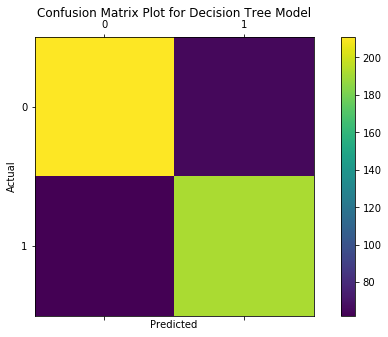

In [26]:
# Nice plot of confusion matrix
# Adjust size of confusion matrix by following code taken from StackOverflow
# https://stackoverflow.com/questions/43021762/matplotlib-how-to-change-figsize-for-matshow
plt.figure(figsize=(10,5))
plt.matshow(cm, fignum=1)

plt.title('Confusion Matrix Plot for Decision Tree Model')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

## Logistic Regression

In [27]:
# Logistic Regression 
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.predict(X_test)
print("Logistic Regression Score: {:.2f}".format(lr.score(X_test, y_test)))

Logistic Regression Score: 0.62


/Users/scottlew/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [28]:
# Generate Confusion Matrix for Logistic Regression
actual = y_test
predictions = lr.predict(X_test)
print('Confusion Matrix for Logistic Regression Model')
print()
cm = confusion_matrix(actual,predictions)
print(cm)

Confusion Matrix for Logistic Regression Model

[[204  72]
 [130 124]]


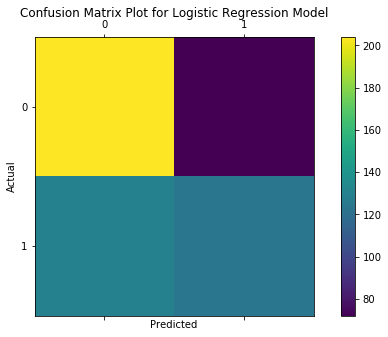

In [29]:
plt.figure(figsize=(10,5))
plt.matshow(cm, fignum=1)

plt.title('Confusion Matrix Plot for Logistic Regression Model')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

## Multi class Classification Using All The Data

In [30]:
df = df.sample(frac=1)
df.head(3)

,label,name,sequence,location,MW,grav,instability,isoelectric,aromaticity,helix,turn,sheet
4156,nuclear.fasta,P49592,MDMDVGKSKDASKATMTKKMDVRVARDADCCVNVSSSNDVCNKDKR...,7,10969.3995,-0.570297,27.764356,9.674011,0.049505,0.168317,0.198020,0.227723
5464,plasma_membrane.fasta,P41217 SP 30,MRVRMSHSTYSVWVMAAVVCTAVVVTDRYTASKCSNAAVTWKKKAV...,9,19678.0609,-0.392265,16.639227,9.841125,0.077348,0.243094,0.265193,0.104972
3829,nuclear.fasta,Q13362,MTCNKAGSRMVVDAANSNGVVHRDVADKKRCCVDVSDSDKWKVKRA...,7,34376.6635,-1.045364,23.597020,10.037903,0.079470,0.185430,0.195364,0.168874


In [31]:
predictors = ['MW', 'grav', 'instability', 'isoelectric','aromaticity', 'helix','turn','sheet']
X = df[predictors]
y = df.location

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state =42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4767, 8) (4767,)
(1192, 8) (1192,)


In [32]:
dtc = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
predictions = dtc.predict(X_test)
print("Decision Tree Classifier Score: {:.2f}".format(dtc.score(X_test, y_test)))

Decision Tree Classifier Score: 0.38


In [33]:
# Generate Confusion Matrix for Decision Tree Classifier
actual = y_test
predictions = dtc.predict(X_test)
print('Confusion Matrix for Decision Tree Model Using All of the Dataset')
print()
cm = confusion_matrix(actual,predictions)
print(cm)

Confusion Matrix for Decision Tree Model Using All of the Dataset

[[  6   0   3  10   5   3   2   6   1   1   2]
 [  1   5   4  10   0   1   5   6   0   8   1]
 [  3   4  32  19   6   3  13  12   2   8   1]
 [ 14   4  14 123  26   0  28  44   7  20   3]
 [  3   0  15  30  64   2   6  15   1  22   3]
 [  1   0   3   3   2   2   1   0   0  10   4]
 [  2   6   9  18  12   1  22   8   7   6   1]
 [  1   0   2  36  12   0  11  69   1  17   2]
 [  2   3   4   9   1   0   3   5   2   6   0]
 [ 11   9  11  23  27   6  10  17   6 125   1]
 [  0   1   0   1   2   3   1   1   0   4   2]]


In [34]:
# Logistic Regression 
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.predict(X_test)
print("Logistic Regression Score: {:.2f}".format(lr.score(X_test, y_test)))

Logistic Regression Score: 0.31


/Users/scottlew/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/scottlew/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [35]:
# Generate Confusion Matrix for Logistic Regression
actual = y_test
predictions = lr.predict(X_test)
print('Confusion Matrix for Logistic Regression Model')
print()
cm = confusion_matrix(actual,predictions)
print(cm)

Confusion Matrix for Logistic Regression Model

[[  0   0   0  26   3   0   0   3   0   7   0]
 [  0   0   0  17   2   0   0  10   0  12   0]
 [  0   0   0  60  25   0   0  13   0   5   0]
 [  0   0   0 175  29   0   0  23   0  56   0]
 [  0   0   0  68  55   0   0  28   0  10   0]
 [  0   0   0  17   1   0   0   2   0   6   0]
 [  0   0   0  61  15   0   0  12   0   4   0]
 [  0   0   0  38  17   0   0  53   0  43   0]
 [  0   0   0  19   4   0   0   7   0   5   0]
 [  0   0   0 104  21   0   0  31   0  90   0]
 [  0   0   0  10   0   0   0   1   0   4   0]]


## Radius Neighbor Classifier

In [38]:
from sklearn.neighbors import RadiusNeighborsClassifier
neigh = RadiusNeighborsClassifier(radius=1.0)
neigh.fit(X_train, y_train) 
print("Radius Neighbor Score: {:.2f}".format(lr.score(X_test, y_test)))

Radius Neighbor Score: 0.31


## Ridge Classifier

In [39]:
from sklearn.linear_model import RidgeClassifier

rdg = RidgeClassifier().fit(X_train, y_train)
print("Ridge Classifier Score: {:.2f}".format(rdg.score(X_test, y_test)))

Ridge Classifier Score: 0.42
